In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

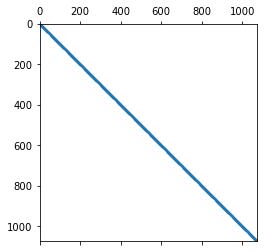

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/b1_ss/"
path = "~/Downloads/pores_1/"
path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)

np.linalg.cond(A.toarray())

In [8]:
N = A.shape[0]
b = np.ones((N))
print
b = np.random.uniform(N)
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

IndexError: tuple index out of range

In [4]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[-4.4408921e-16 -4.4408921e-16 -4.4408921e-16 ... -4.4408921e-16
 -4.4408921e-16 -4.4408921e-16]


In [5]:
np.linalg.cond(A.toarray())

8266217.206972408

In [6]:
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d


def powers(M, A, r):
    M[0] = r
    for i in range(1, len(M)):
        M[i] = A @ M[i-1]


def scalar_work(i, P):
    W = np.array([[pj @ A @ pi.T for pj in P] for pi in P])
    Winv = np.linalg.inv(W)
    r, s = P[0], len(P)
    m = np.array([r @ p for p in P])
    alpha = Winv @ m
    beta = np.zeros([s, s])
    if i > 0:
        c = np.zeros(s)
        Akr = r
        c[-1] = - r @ Akr / alpha[-1]
        beta[0] = -c @ Winv
        for k in range(1, s):
            Akr = A @ Akr
            c[:-1] = c[1:]
            rest = sum([alpha[-2-t] * c[-2-t] for t in range(k)])
            c[-1] = -1 / alpha[-1] * ((r @ Akr) + rest)
            beta[k] = -c @ Winv
    return alpha, beta


def s_cg(A, b, s=4):
    x = np.zeros(b.shape)
    P = np.zeros([s, len(b)])
    Q = np.zeros([s, len(b)])
    powers(Q, A, b - A @ x)
    for i in range(9):
        print(f"{i=}")
        alpha, beta = scalar_work(i, Q)
        Q += beta @ P
        print(f"{Q @ P.T=}")
        # assert np.all(np.isclose(np.zeros(s), Q @ P.T)), "Not orthogonal."
        x += alpha @ Q
        check(x, b)
        powers(P, A, b - A @ x)
        P, Q = Q, P
    return x


s_cg_sol = s_cg(A, b)
print(np.linalg.norm(s_cg_sol @ A - b))

i=0
Q @ P.T=array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])
i=1
Q @ P.T=array([[ 1.38957797e+04,  9.72234010e+06, -2.33246095e+12,
        -5.08562019e+18],
       [ 1.68822820e+10,  1.06397290e+13, -4.88333552e+18,
         1.02281950e+25],
       [ 2.15310344e+16,  1.21070115e+19,  1.16425098e+25,
         5.38127083e+31],
       [ 2.81378561e+22,  3.41529882e+25,  5.64546380e+31,
         1.37869322e+38]])
i=2
Q @ P.T=array([[2.48382204e+04, 2.60453001e+10, 4.14807291e+16, 6.01143801e+22],
       [3.44533765e+10, 3.87925958e+16, 4.96263543e+22, 6.43496956e+28],
       [3.91416797e+16, 4.16196826e+22, 5.07796572e+28, 6.39990745e+34],
       [3.73223468e+22, 3.71385252e+28, 4.39747458e+34, 5.42050750e+40]])
i=3
Q @ P.T=array([[ 7.12552861e+05,  3.05970527e+11,  2.82346153e+17,
         2.85005533e+23],
       [ 2.12523008e+11,  3.31972664e+17,  4.18794693e+23,
         4.10666076e+29],
       [-4.22592403e+17,  3.66629478e+23,  5.91